# EDA

You will need to download the data provided by SteadySun from the GCP bucket.
```bash
gsutil -m cp -r "gs://steadycast/Images/MSG/Chambéry/2022" .
```

this will download the 2022 folder where you have subfolders for months of May and ~June~.

## Loading data

In [1]:
import random
from pathlib import Path

from fastprogress import progress_bar

In [2]:
def ls(path): return sorted(list(path.iterdir()))

In [3]:
data_path = Path("2022")

only one file here!

In [4]:
files = ls(data_path/"06/05")
one_file = random.choice(files)
other_file = random.choice(files)

In [5]:
files.sort()
files[0:10]

[PosixPath('2022/06/05/MSG_Chambéry_202206050000.nc'),
 PosixPath('2022/06/05/MSG_Chambéry_202206050015.nc'),
 PosixPath('2022/06/05/MSG_Chambéry_202206050030.nc'),
 PosixPath('2022/06/05/MSG_Chambéry_202206050045.nc'),
 PosixPath('2022/06/05/MSG_Chambéry_202206050100.nc'),
 PosixPath('2022/06/05/MSG_Chambéry_202206050115.nc'),
 PosixPath('2022/06/05/MSG_Chambéry_202206050130.nc'),
 PosixPath('2022/06/05/MSG_Chambéry_202206050145.nc'),
 PosixPath('2022/06/05/MSG_Chambéry_202206050200.nc'),
 PosixPath('2022/06/05/MSG_Chambéry_202206050215.nc')]

The data is in xarray format `NetCDF4`

In [6]:
import wandb

import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from utils import *

In [7]:
def add_time_dim(ds):
    return ds.expand_dims(time=[pd.to_datetime(ds.time)])

def stack_files(files):
    return xr.concat([add_time_dim(xr.open_dataset(f)) for f in files], dim="time")    

In [8]:
ds = stack_files(files)

In [9]:
ds.info()

xarray.Dataset {
dimensions:
	time = 93 ;
	latitude = 446 ;
	longitude = 780 ;

variables:
	datetime64[ns] time(time) ;
	float32 HRV(time, latitude, longitude) ;
	float64 longitude(longitude) ;
		longitude:units = degrees_east ;
		longitude:long_name = Longitude ;
	float64 latitude(latitude) ;
		latitude:units = degrees_north ;
		latitude:long_name = Latitude ;
	float32 VIS(time, latitude, longitude) ;
	float32 B03(time, latitude, longitude) ;
	float32 B04(time, latitude, longitude) ;
	float32 B07(time, latitude, longitude) ;
	float32 B09(time, latitude, longitude) ;
	float32 B11(time, latitude, longitude) ;
	float32 IR108(time, latitude, longitude) ;
	float32 B15(time, latitude, longitude) ;
	float32 B16(time, latitude, longitude) ;
	float32 B14(time, latitude, longitude) ;

// global attributes:
	:Conventions = CF-1.6 ;
	:time = 2022-06-05 00:00:00 ;
	:description = Satellite image for zone Chambéry ;
}

In [10]:
start_n = 20
idxs = slice(start_n, start_n+4)

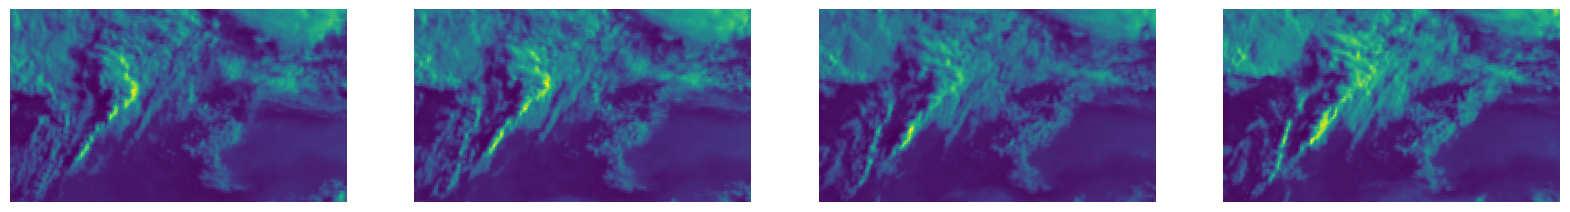

In [11]:
show_images(ds.VIS.values[idxs], figsize=(20,20))

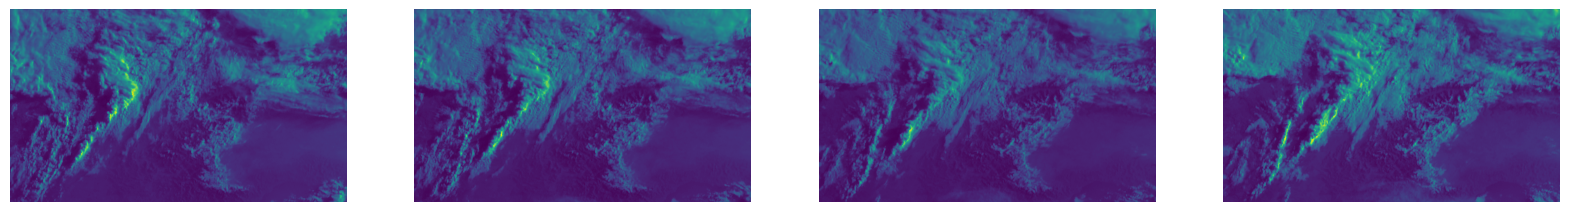

In [12]:
show_images(ds.HRV.values[idxs], figsize=(20,20))

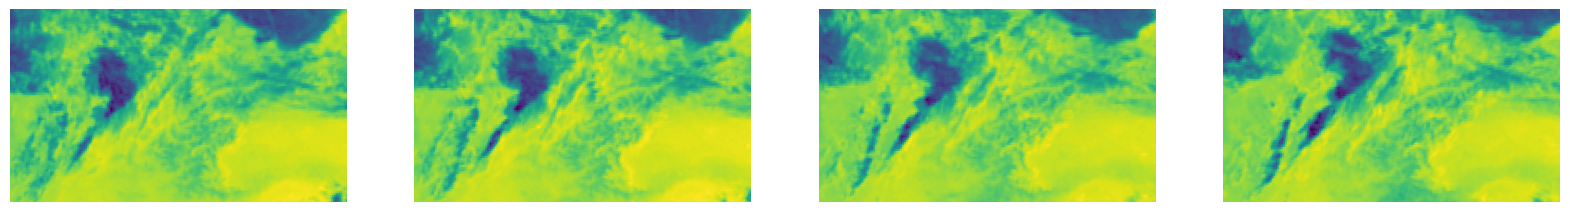

In [13]:
show_images(ds.B07.values[idxs], figsize=(20,20))

In [14]:
ds.VIS.shape

(93, 446, 780)

## Exporting to bare numpy

In [15]:
All = list(ds.keys())

In [16]:
ds[["VIS", "B07"]]

<xarray.Dataset>
Dimensions:    (time: 93, latitude: 446, longitude: 780)
Coordinates:
  * time       (time) datetime64[ns] 2022-06-05 ... 2022-06-05T23:45:00
  * longitude  (longitude) float64 3.004 3.013 3.022 3.031 ... 9.978 9.986 9.995
  * latitude   (latitude) float64 48.0 47.99 47.98 47.97 ... 44.02 44.01 44.0
Data variables:
    VIS        (time, latitude, longitude) float32 0.01052 0.01052 ... 0.009472
    B07        (time, latitude, longitude) float32 237.6 237.6 ... 284.0 284.0
Attributes:
    Conventions:  CF-1.6
    time:         2022-06-05 00:00:00
    description:  Satellite image for zone Chambéry

In [17]:
def ds_to_np(ds, keys=All, axis=1):
    "Stack the xarray.Dataset into a fast numpy array"
    raw_np_values = []
    for k in keys:
        raw_np_values.append(ds[k].values)
    stacked_ds = np.stack(raw_np_values, axis=axis)
    return stacked_ds

one day of data = 93 timesteps

In [40]:
np_ds = ds_to_np(ds, ["VIS", "B07"])
np_ds.shape

(93, 2, 446, 780)

## process all data

In [18]:
EXPORT_PATH = Path("np_data")

In [19]:
days = ls(data_path/"06/")
days

[PosixPath('2022/06/01'),
 PosixPath('2022/06/02'),
 PosixPath('2022/06/03'),
 PosixPath('2022/06/04'),
 PosixPath('2022/06/05'),
 PosixPath('2022/06/06'),
 PosixPath('2022/06/07'),
 PosixPath('2022/06/08'),
 PosixPath('2022/06/09'),
 PosixPath('2022/06/10'),
 PosixPath('2022/06/11'),
 PosixPath('2022/06/12'),
 PosixPath('2022/06/13'),
 PosixPath('2022/06/14'),
 PosixPath('2022/06/15'),
 PosixPath('2022/06/16'),
 PosixPath('2022/06/17'),
 PosixPath('2022/06/18'),
 PosixPath('2022/06/19'),
 PosixPath('2022/06/20'),
 PosixPath('2022/06/21'),
 PosixPath('2022/06/22'),
 PosixPath('2022/06/23'),
 PosixPath('2022/06/24'),
 PosixPath('2022/06/25'),
 PosixPath('2022/06/26'),
 PosixPath('2022/06/27'),
 PosixPath('2022/06/28'),
 PosixPath('2022/06/29'),
 PosixPath('2022/06/30')]

In [20]:
day = days[0]

In [21]:
str(day).replace("/", "_")

'2022_06_01'

In [ ]:
for day in progress_bar(days):
    files = ls(day)
    ds = stack_files(files)
    np_ds = ds_to_np(ds, keys=["B07"])
    fname = "B07_" + str(day).replace("/", "_") + ".npy"
    np.save(EXPORT_PATH/fname, np_ds)

## Log to W&B

In [23]:
ds.attrs

{'Conventions': 'CF-1.6',
 'time': '2022-06-02 00:00:00',
 'description': 'Satellite image for zone Chambéry'}

In [24]:
import cv2
from fastprogress import progress_bar

In [25]:
columns = list(ds.keys())

columns = ["date"] + columns
columns

['date',
 'HRV',
 'VIS',
 'B03',
 'B04',
 'B07',
 'B09',
 'B11',
 'IR108',
 'B15',
 'B16',
 'B14']

In [26]:
n = -1
resize_factor = 2

In [27]:
orig_size = ds.HRV.values.shape
new_size = (orig_size[2]//resize_factor, orig_size[1]//resize_factor)
orig_size, new_size

((96, 446, 780), (390, 223))

In [28]:
def get_stats(ds):
    stats = []
    for k, v in ds.items():
        stats.append([k, v.values.min(), v.values.max(), v.values.mean(), v.values.std()])
    return pd.DataFrame(data=stats, columns=["Variable", "min", "max", "mean", "std"])

In [29]:
get_stats(ds)

,Variable,min,max,mean,std
0,HRV,0.000000,0.994918,0.122012,0.149452
1,VIS,0.000000,0.848435,0.098474,0.134538
2,B03,0.000000,0.915893,0.150845,0.164274
3,B04,0.000000,0.638842,0.105735,0.112227
4,B07,-2.968737,310.734924,276.130524,17.315426
5,B09,209.556244,238.275040,230.623001,3.776659
6,B11,208.044968,303.265900,267.749573,18.791365
7,IR108,207.759598,306.241150,268.831268,19.814060
8,B15,209.064774,301.964081,266.832458,19.417538
9,B16,211.348679,269.157837,249.886673,11.771256


In [30]:
def scale(arr):
    "Scales values of array in [0,1]"
    m, M = arr.min(), arr.max()
    return (arr - m) / (M - n)

In [31]:
k = All[1]
print(k)

scaled_vis = scale(ds[k].values)
scaled_vis.shape

VIS


(96, 446, 780)

In [33]:
def preprocess_frames(data, new_size):
    sdata = scale(data)
    def resize(frame):
        rframe = 255 * cv2.resize(frame, new_size)
        return rframe.astype(np.uint8)
    return [resize(frame) for frame in sdata]

In [34]:
def create_row(ds):
    sequences = {}
    for k in progress_bar(All):
        data = ds[k].values
        images = preprocess_frames(data, new_size)
        vid = np.stack(images)[:, None, ...]
        sequences[k] = wandb.Video(vid)
    return sequences

In [35]:
table = wandb.Table(columns = columns)
for day in progress_bar(days, leave=False):
    ds = stack_files(ls(day))
    sequences = create_row(ds)
    table.add_data(*[ds.attrs["time"]] + list(sequences.values()))

In [36]:
with wandb.init(project="xarray"):
    wandb.log({f"vid_06": table})    

wandb: Currently logged in as: capecape. Use `wandb login --relogin` to force relogin
